Installing pre-requisites

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 89.4MB 37kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 1


The notebook is divided into 3 parts:
- In the first part we import the images and create the dataframe
- In the second part we define our embedding network and train it on the given images
- In the last part we use the embedding network to create a classifier and use it to classify the given images

## Part 1: Data import and dataframe creation

Importing important libraries for the section

In [3]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

Rather than importing all the images together, we shall create a dataframe with Image path and respective label "string type", and then encode the labels "numeral type". This makes the execution faster by only importing selected images at a time.

In [4]:
#to replicate the results just replace the path below with the path to your train folder
pathToDataset = '/content/drive/MyDrive/MIDAS/TASK 1/train/'

In [5]:
imagePath = []
labels = []
for folder in os.listdir(pathToDataset):
    for images in os.listdir(os.path.join(pathToDataset,folder)):
        image = os.path.join(pathToDataset,folder,images)
        imagePath.append(image)
        labels.append(folder)
data = {'Images':imagePath, 'Labels':labels}
data = pd.DataFrame(data)
data.head()

,Images,Labels
0,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006
1,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006
2,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006
3,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006
4,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006


Now that  we have the Image path and their respective labels, we shall encode these labels to their numerical counterparts for our deep learning model.

In [6]:
labelEncoder = LabelEncoder()
data['Encoded Labels'] = labelEncoder.fit_transform(data['Labels'])
data.head()

,Images,Labels,Encoded Labels
0,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006,5
1,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006,5
2,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006,5
3,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006,5
4,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample006,5


In [7]:
data.tail()

,Images,Labels,Encoded Labels
2475,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample059,58
2476,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample059,58
2477,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample059,58
2478,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample059,58
2479,/content/drive/MyDrive/MIDAS/TASK 1/train/Samp...,Sample059,58


We now create the training and validation splits of the images.

In [8]:
batchSize = 128
validationSplit = 0.15
shuffleDataset = True
randomSeed = 17

In [9]:
datasetSize = len(data)
indices = list(range(datasetSize))
split = int(np.floor(validationSplit*datasetSize))
if shuffleDataset:
    np.random.seed(randomSeed)
    np.random.shuffle(indices)
trainIndices, validationIndices = indices[split:], indices[:split]

In [10]:
trainSampler = SubsetRandomSampler(trainIndices)
validationSampler = SubsetRandomSampler(validationIndices)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, imageData, imagePath, transform=None):
        self.imagePath = imagePath
        self.imageData = imageData
        self.transform = transform
    def __len__(self):
        return len(self.imageData)
    def __getitem__(self, index):
        imageName = os.path.join(self.imagePath, self.imageData.loc[index, 'Labels'],self.imageData.loc[index,'Images'])
        image = Image.open(imageName).convert('L')
        image = image.resize((32,32))
        label = torch.tensor(self.imageData.loc[index, 'Encoded Labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image,label

We now create  the custom dataset using all the images

In [12]:
transform = transforms.Compose(
    [transforms.Resize(220),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

In [13]:
dataset = CustomDataset(data,pathToDataset,transform)

We create train and validation loaders that will load batches of images for training and validation using the indices we created above

In [14]:
trainLoader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, sampler = trainSampler)
validationLoader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, sampler = validationSampler)

To visualize the images, we  first need to unormalize  them, this is performed in the function below

In [15]:
def  displayImage(image):
    image = image/2 + 0.5
    image = image.numpy()
    image = image.reshape(220,220)
    return image

We now visualize some of our training images

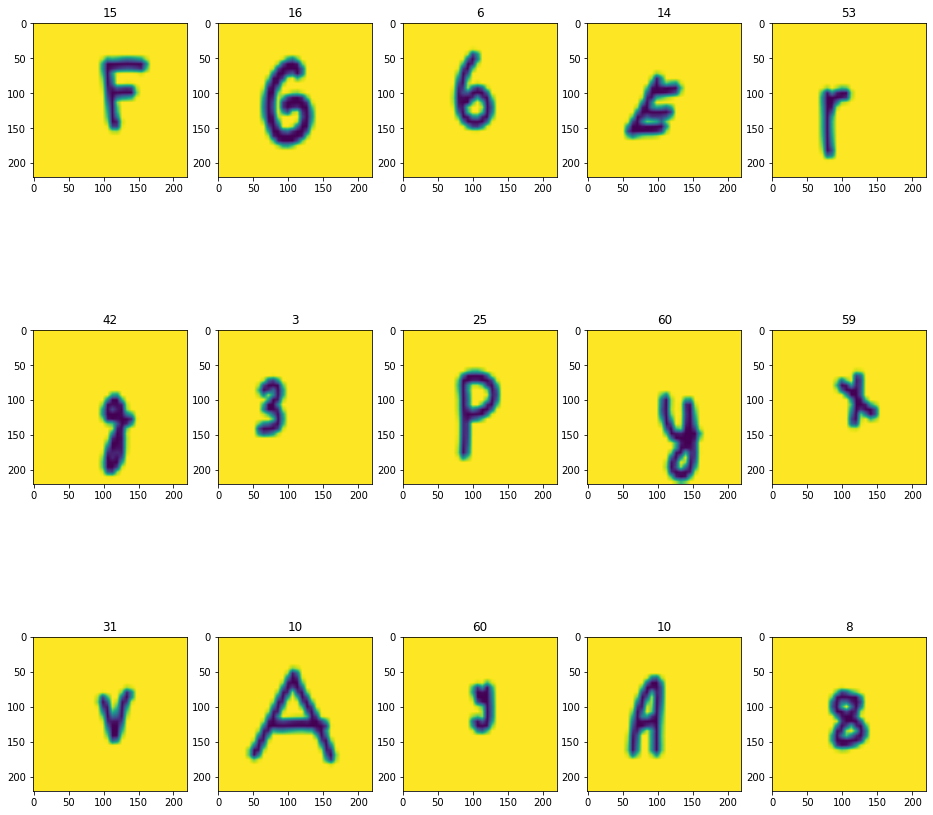

In [16]:
dataIterator = iter(trainLoader)
images, labels = dataIterator.next()
figure, axis = plt.subplots(3,5, figsize=(16,16))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(displayImage(image))
        ax.set(title=f"{label.item()}")

## Part 2: Embedding Network and its training

Importing important libraries for the section

In [17]:
#the pytorch metric learning library comes with inbuilt methods for triplet mining and computing triplet losses between anchor, positive class and negative class
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training the model on: ",device)

Training the model on:  cuda:0


We now define our embedding network, the network is based on ZFNet the Zeilur and Fergus Neural Network with a few modifications.

In [19]:
class EmbeddingNetwork(nn.Module):
    def __init__(self):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (7,7), stride=(2,2), padding=(3,3)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3, 3), 2, padding=(1,1))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,(1,1), stride=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.Conv2d(64,192, (3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192,192,(1,1), stride=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.Conv2d(192,384,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3), 2, padding=(1,1))
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384,384,(1,1), stride=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.Conv2d(384,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1)),
            nn.Flatten()
        )
        self.fullyConnected = nn.Sequential(
            nn.Linear(7*7*256,32*128),
            nn.BatchNorm1d(32*128),
            nn.LeakyReLU(0.001),
            nn.Linear(32*128,128)
        )
    def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.fullyConnected(x)
      return torch.nn.functional.normalize(x, p=2, dim=-1)

We shall now create the embedding model and print its layers

In [20]:
embeddingNetwork = EmbeddingNetwork().to(device)
print(embeddingNetwork)

EmbeddingNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.001)
    (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affin

The train function below  takes this Embedding model along with the training loaded, the triplet miner and the triplet loss function to train the embedding network for a single epoch

In [21]:
def train(model, lossFunction, miningFunction, device, trainLoader, optimizer, epoch):
    print("Training started for Epoch: ",epoch)
    model.train()
    for batchIndex, (data, labels) in enumerate(trainLoader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        hardPairs = miningFunction(embeddings, labels)
        loss = lossFunction(embeddings, labels, hardPairs)
        loss.backward()
        optimizer.step()
        if batchIndex%20==0:
            print("Training stats for Epoch {} Iteration {}: Loss= {}, Number of mined triplets {}".format(epoch, batchIndex, loss, miningFunction.num_triplets))

We now define the loss function, triplet miner, optimizer, and other important hyperparamters we will be using to trai the model

In [22]:
#distance this tells the model how to calculate the distance between the  generated embeddings
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0.0)
lossFunction = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
miningFunction = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semi-hard")
optimizer = torch.optim.Adam(embeddingNetwork.parameters(), lr=0.05)

The function below tests the embedding model using a simple KNN classifier and saves the weights for the best embedding model depending on the validation accuracy of the classifier. These embedding weights will be used later to create our classifier.

In [23]:
def tester(maxValidationAccuracy):
  trainEmbeddings = []
  trainLabels = []
  validationEmbeddings = []
  validationLabels = []
  with torch.no_grad():
    embeddingNetwork.eval()
    for (dataTr, labelTr) in (trainLoader):
      dataTr, labelTr = dataTr.to(device), labelTr.to(device)
      embeddingTr = embeddingNetwork(dataTr)
      trainEmbeddings.append(embeddingTr.cpu().detach().numpy())
      trainLabels.append(labelTr.cpu().detach().numpy())
    for (dataTe, labelTe) in (validationLoader):
      dataTe, labelTe = dataTe.to(device), labelTe.to(device)
      embeddingsTe = embeddingNetwork(dataTe)
      validationEmbeddings.append(embeddingsTe.cpu().detach().numpy())
      validationLabels.append(labelTe.cpu().detach().numpy())
  trainEmbeddings1 = []
  trainLabels1 = []
  validationEmbeddings1 = []
  validationLabels1 = []
  for bat in trainEmbeddings:
    for exm in bat:
      trainEmbeddings1.append(exm)
  for bat in trainLabels:
    for exm in bat:
      trainLabels1.append(exm)
  for bat in validationEmbeddings:
    for exm in bat:
      validationEmbeddings1.append(exm)
  for bat in validationLabels:
    for exm in bat:
      validationLabels1.append(exm)
  neigh = KNeighborsClassifier(n_neighbors=13)
  neigh.fit(trainEmbeddings1, trainLabels1)
  prediction = neigh.predict(validationEmbeddings1)
  currentAccuracy = accuracy_score(validationLabels1,prediction)
  print("Accuracy: ",currentAccuracy)
  if currentAccuracy > maxValidationAccuracy:
    maxValidationAccuracy = currentAccuracy
    print("New highest validation accuracy, saving the embedding model")
    torch.save(embeddingNetwork.state_dict(), "embeddingNetworkTask1.pt")
  return maxValidationAccuracy

The snippet below uses the above function to train the embedding model for 80 epochs or around 2000 iterations, while this is only about 2/5th of the total interations used in FaceNet, I had to cut the training short due to time shortage.

In [24]:
maxValidationAccuracyEmbedding = 0
for epoch in range(1, 81):
    train(embeddingNetwork, lossFunction, miningFunction, device, trainLoader, optimizer, epoch)
    print("Training completed for the Epoch:", epoch)
    maxValidationAccuracyEmbedding = tester(maxValidationAccuracyEmbedding)

Training started for Epoch:  1
Training stats for Epoch 1 Iteration 0: Loss= 0.1719743013381958, Number of mined triplets 23935
Training completed for the Epoch: 1
Accuracy:  0.1478494623655914
New highest validation accuracy, saving the embedding model
Training started for Epoch:  2
Training stats for Epoch 2 Iteration 0: Loss= 0.20043489336967468, Number of mined triplets 18343
Training completed for the Epoch: 2
Accuracy:  0.15591397849462366
New highest validation accuracy, saving the embedding model
Training started for Epoch:  3
Training stats for Epoch 3 Iteration 0: Loss= 0.1959235519170761, Number of mined triplets 13187
Training completed for the Epoch: 3
Accuracy:  0.25
New highest validation accuracy, saving the embedding model
Training started for Epoch:  4
Training stats for Epoch 4 Iteration 0: Loss= 0.18232952058315277, Number of mined triplets 10326
Training completed for the Epoch: 4
Accuracy:  0.3118279569892473
New highest validation accuracy, saving the embedding m

## Part 3: Training the Classifier

Now that our embedding model is trained, we will use it to create the classifier network

In [25]:
class classifierNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(classifierNet, self).__init__()
        self.embeddingLayer = EmbeddingNet
        self.linearLayer = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.classifierLayer = nn.Linear(64,62)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.embeddingLayer(x))
        x = self.dropout(self.linearLayer(x))
        x = self.classifierLayer(x)
        return F.log_softmax(x, dim=1)

Now we will create our classifier model using the embedding network with best validation accuracy and print its layers

In [26]:
bestEmbeddingNetwork = EmbeddingNetwork().to(device)
bestEmbeddingNetwork.load_state_dict(torch.load('embeddingNetworkTask1.pt'))

<All keys matched successfully>

In [27]:
classifier = classifierNet(embeddingNetwork).to(device)
print(classifier)

classifierNet(
  (embeddingLayer): EmbeddingNetwork(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.001)
      (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(192, 192, kernel_size=(1, 1), st

Before we begin the training of our classifier, we shall  freeze the weights of our embedding network as we don't want to train our embedding network, we shall only be training the linear layer(s)

In [28]:
for param in classifier.embeddingLayer.parameters():
    param.requires_grad = False

We now define our Cross Entropy Loss function to train the classifier, the new optimizer and an accuracy function to test our model. Since our outputs from the embedding network are L2 Normalized we can keep a high learning rate.

In [29]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
def accuracy(output, labels):
    _, predictions = torch.max(output, dim=1)
    return torch.sum(predictions==labels).item()

Now that the prerequisites for our classifier are done, we can write the training and testing steps

In [30]:
numberOfEpochs = 20
validAccuracyMin = 0
validationLoss = []
validationAccuracy = []
trainingLoss = []
trainingAccuracy = []
totalSteps = len(trainLoader)
for epoch in range(1, numberOfEpochs):
    classifier.train()
    runningLoss = 0.0
    correct = 0
    total = 0
    print("Training started for Epoch: ",epoch)
    for batchIndex, (data, target) in enumerate(trainLoader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = classifier(data)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        if (batchIndex)%10 ==0:
            print("Epoch [{}/{}] Step [{}/{}] Loss: {:.4f}".format(epoch,numberOfEpochs,batchIndex,totalSteps,loss.item()))
    trainingAccuracy.append(100*correct/total)
    trainingLoss.append(runningLoss/totalSteps)
    print("Training Accuracy: ",(100*correct/total))
    batchLoss = 0
    totalV = 0
    correctV = 0
    with torch.no_grad():
        classifier.eval()
        for dataV, targetV in (validationLoader):
            dataV, targetV = dataV.to(device), targetV.to(device)
            outputV = classifier(dataV)
            lossV = criterion(outputV,targetV)
            batchLoss += lossV.item()
            _, predV = torch.max(outputV, dim=1)
            correctV += torch.sum(predV==targetV).item()
            totalV += targetV.size(0)
        validationAccuracy.append(100*correctV/totalV)
        validationLoss.append(batchLoss/len(validationLoader))
        print("Validation Accuracy: ",(100*correctV/totalV))
        if (100*correctV/totalV)>validAccuracyMin:
            validAccuracyMin = 100*correctV/totalV
            print("Validation accuracy improved, network improvement detected, saving network")
            torch.save(classifier.state_dict(), "classifierNetworkTask1.pt")

    classifier.train()
                

Training started for Epoch:  1
Epoch [1/20] Step [0/17] Loss: 4.1162
Epoch [1/20] Step [10/17] Loss: 3.8026
Training Accuracy:  16.03415559772296
Validation Accuracy:  55.10752688172043
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  2
Epoch [2/20] Step [0/17] Loss: 3.2544
Epoch [2/20] Step [10/17] Loss: 2.0851
Training Accuracy:  58.8235294117647
Validation Accuracy:  75.80645161290323
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  3
Epoch [3/20] Step [0/17] Loss: 1.3255
Epoch [3/20] Step [10/17] Loss: 0.9339
Training Accuracy:  78.8899430740038
Validation Accuracy:  78.2258064516129
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  4
Epoch [4/20] Step [0/17] Loss: 0.7026
Epoch [4/20] Step [10/17] Loss: 0.5443
Training Accuracy:  83.82352941176471
Validation Accuracy:  81.18279569892474
Validation accuracy improved, netw

Now that the model is trained, we can see the training and validation plots

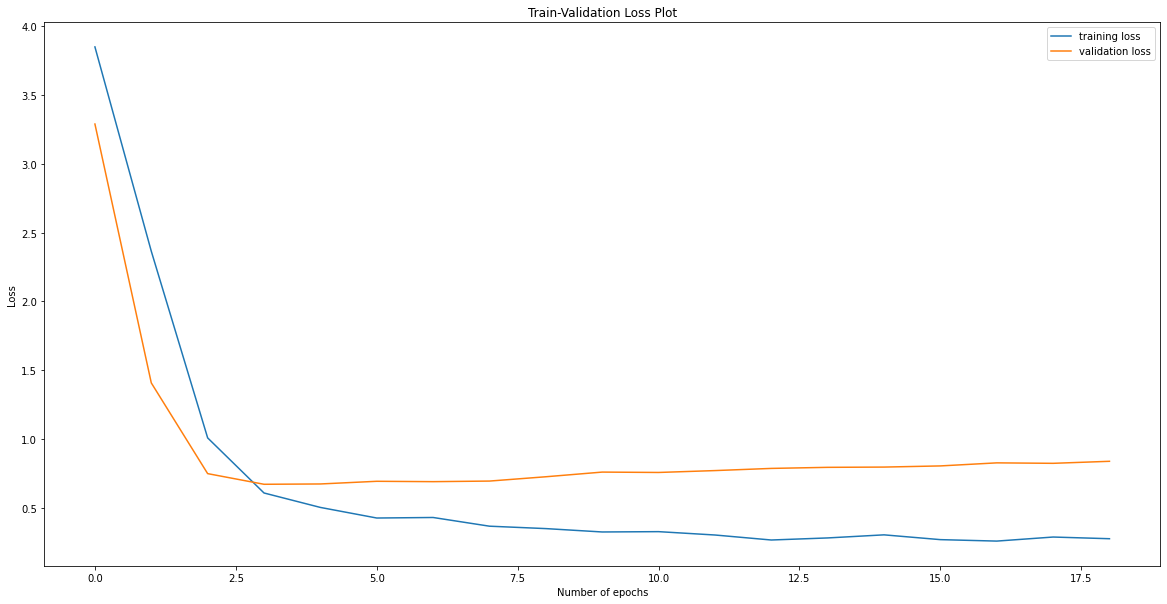

In [31]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss Plot")
plt.plot(trainingLoss, label='training loss')
plt.plot(validationLoss, label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

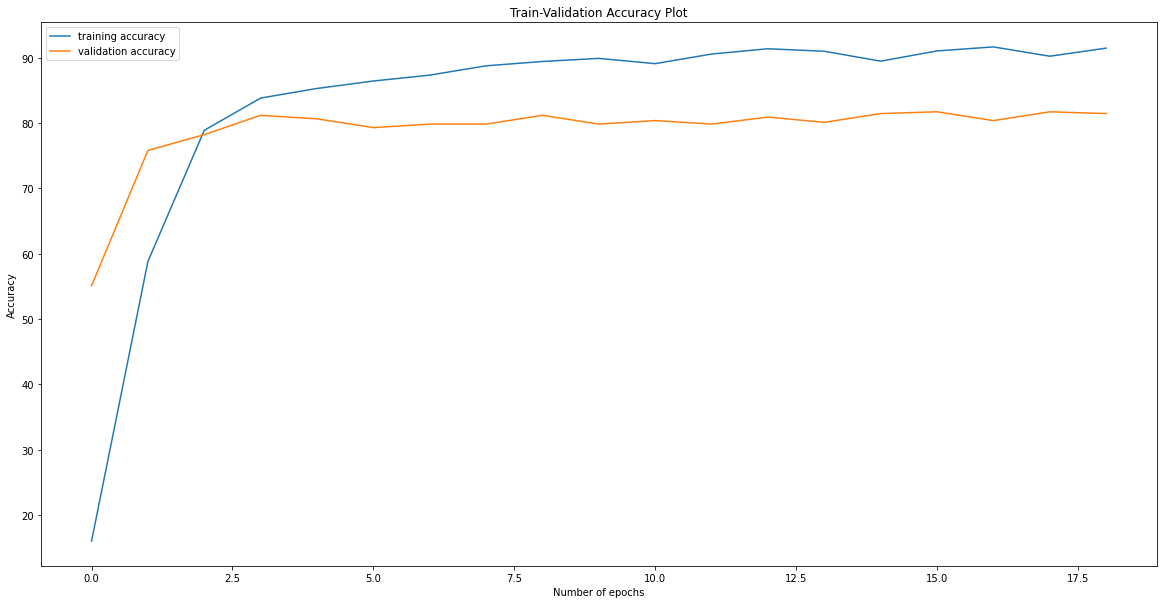

In [32]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Plot")
plt.plot(trainingAccuracy, label='training accuracy')
plt.plot(validationAccuracy, label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')